In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
sns.set(font_scale=1.5)

In [2]:
table_path = Path('../../fits')
product_path = Path('../../postfit_derivatives')

In [3]:
def fix_region_name(roi):
    roi = roi.replace('_', ' ')
    roi = ' '.join(roi.split(',')[::-1]).strip()
    return roi

In [4]:
df = pd.read_csv(table_path / 'fit_table_reweighted.csv')
df['roi'] = df['roi'].apply(fix_region_name)

In [5]:
rois = list(df['roi'].unique())
roi_us = sorted([r for r in rois if r[:3]=='US '])
top25 = pd.read_csv(product_path / "top25.csv", index_col=0, header=None).index
top25 = top25.map(fix_region_name)
roi_other = sorted(list(top25) + ['China'])
rois = roi_us + roi_other
df = df[df['roi'].isin(rois)]
print("There are %d regions under consideration" % len(rois))

There are 56 regions under consideration


### Figure 1

In [5]:
def add_april_15th(df, stats):
    for stat in stats:
        df['%s (April 15th)' % stat] = df.filter(regex=("%s \(w.*" % stat)).apply(lambda x: x.dropna().get(-1, None), axis=1)
    return df

def clean_df(df, stat):
    result = df.set_index(['roi', 'quantile'])[stat].unstack('quantile')
    return result

df = add_april_15th(df, ['Rt', 'car', 'ifr'])

In [53]:
def box_vs_roi(df, stat, labl, sort=True, low=0.12, high=22, palette=None, ax=None, subtract=None):
    sns.set(font_scale=1.2, rc={'ytick.left': True})
    if ax is None:
        fig = plt.figure(figsize=(15, 5))
    else:
        fig = plt.gcf()
    clean = clean_df(df, stat)
    clean = clean.iloc[:, :5] # Only quantiles
    if sort is True:
        clean = clean.sort_values('0.5', ascending=False)
    elif sort is not False:
        clean = clean.loc[sort]
    if subtract:
        clean2 = clean_df(df, subtract)
        clean2 = clean2.loc[clean.index]
        clean2 = clean2.iloc[:, :5] # Only quantiles
        diffs = np.log10(clean2['0.5'] / clean['0.5'])
        import matplotlib.cm as cm
        from matplotlib.colors import Normalize
        cmap = cm.RdBu_r
        norm = Normalize(vmin=-1, vmax=1)
        palette = [cmap(norm(diff)) for diff in diffs]
    else:
        palette = None
    ax = sns.boxplot(data=clean.T, whis=99, ax=ax, palette=palette)
    for i, box in enumerate(ax.artists):
        box.set_edgecolor('black')
        if palette is None:
            box.set_facecolor('white')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=70);
    ax.set_yscale('log')
    from matplotlib.ticker import FormatStrFormatter, FuncFormatter
    if 'R' in stat:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x,_: "%d"%x if x>=1 else '%.1g'%x))
        ax.yaxis.set_minor_formatter(FuncFormatter(lambda x,_: "%d"%x if 1 < x < 6 else ''))

    import matplotlib.transforms
    dx = 7/72.; dy = 0/72. 
    ax.margins(x=0.01, y=0.01)
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')
        label.set_transform(label.get_transform() + offset)
    ax.set_xlim(-1, len(clean))
    ax.set_ylim(low, high)
    ax.set_xlabel('')
    ax.set_ylabel(labl, fontsize=18);
    return list(clean.index)

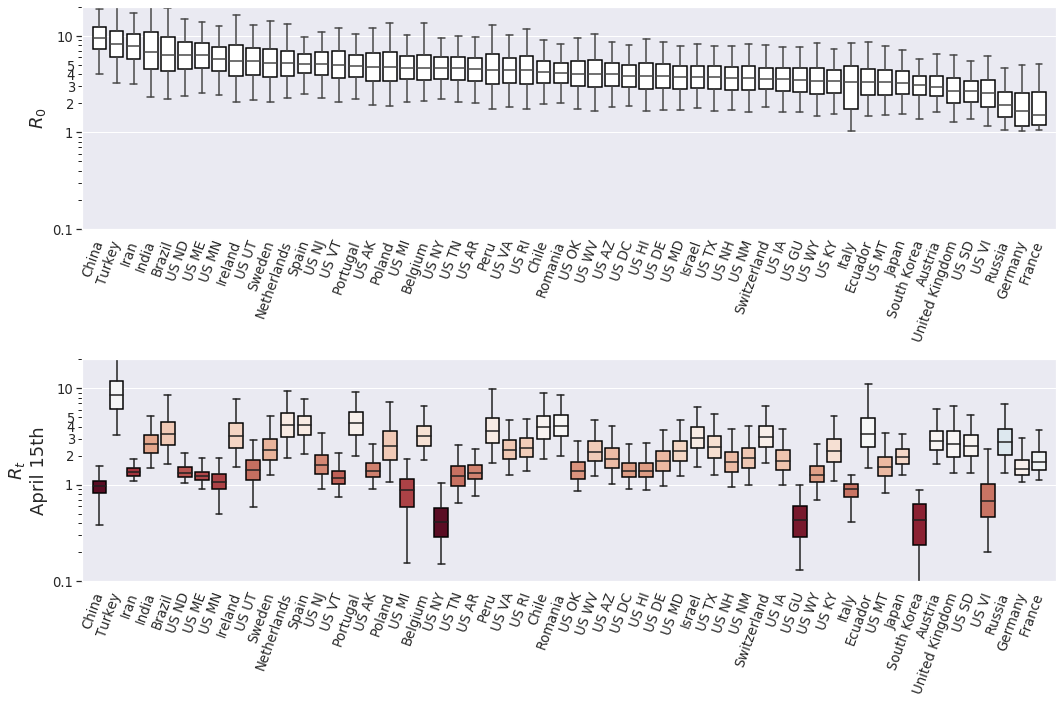

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
rois = box_vs_roi(df, 'R0', '$R_0$', ax=ax[0], low=0.1, high=20);
box_vs_roi(df, 'Rt (April 15th)', '$R_t$\nApril 15th', low=0.1, high=20, ax=ax[1], subtract='R0', sort=rois);
plt.tight_layout()
plt.savefig('Fig1ab.png', dpi=400)

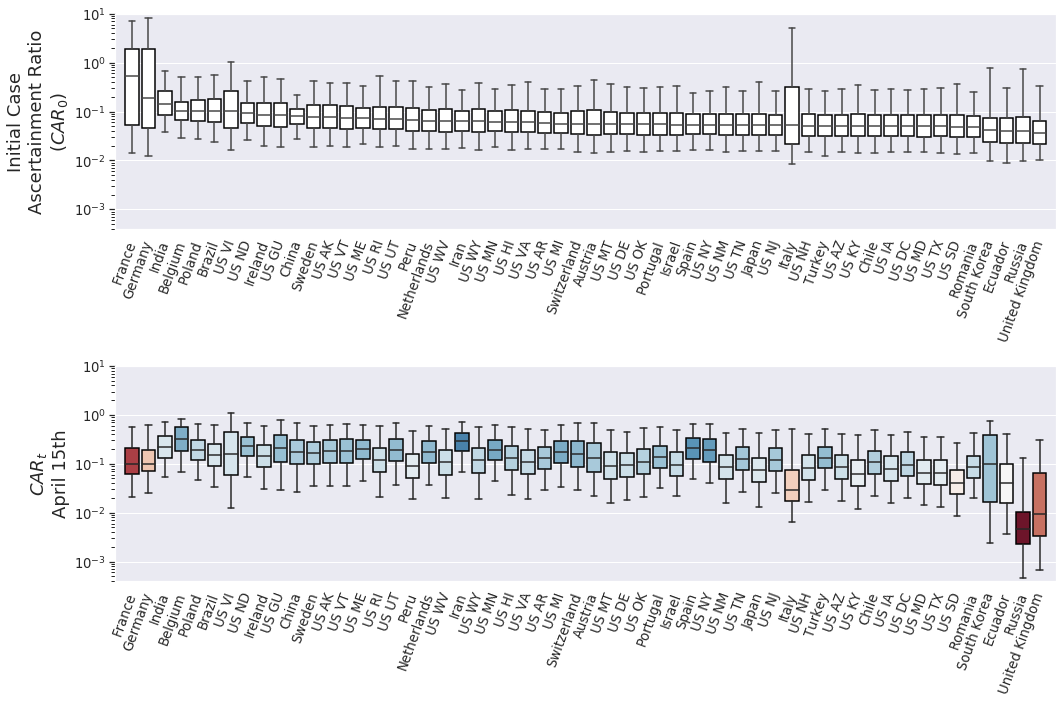

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
rois = box_vs_roi(df, 'car (week 0)', 'Initial Case\nAscertainment Ratio\n($CAR_0$)', ax=ax[0], low=0.0004, high=10);
box_vs_roi(df, 'car (April 15th)', '$CAR_t$\nApril 15th', low=0.0004, high=10, ax=ax[1], subtract='car (week 0)', sort=rois);
plt.tight_layout()
plt.savefig('Fig1cd.png', dpi=400)

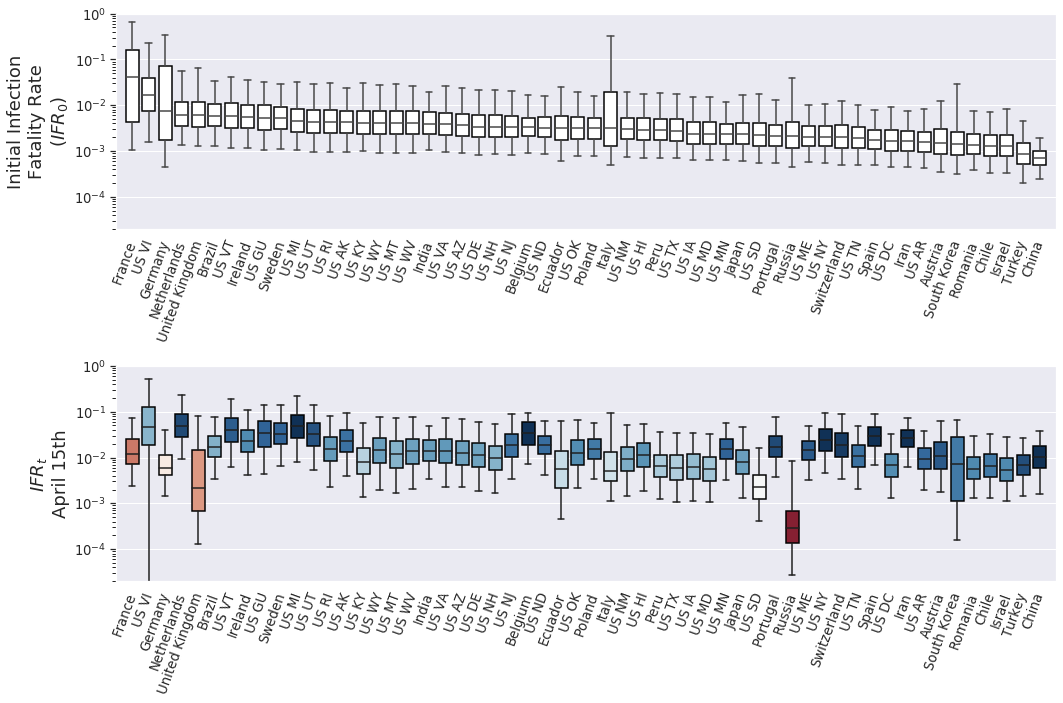

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
rois = box_vs_roi(df, 'ifr (week 0)', 'Initial Infection\nFatality Rate\n($IFR_0$)', ax=ax[0], low=2e-5, high=1);
box_vs_roi(df, 'ifr (April 15th)', '$IFR_t$\nApril 15th', low=2e-5, high=1, ax=ax[1], subtract='ifr (week 0)', sort=rois);
plt.tight_layout()
plt.savefig('Fig1ef.png', dpi=400)

In [6]:
def get_global(df):
    # Compute global stats
    df = df.set_index(['roi', 'quantile'])
    df.columns.name = 'param'
    means = df.unstack('roi').loc['mean'].unstack('param')
    weights = (1/df.unstack('roi').loc['std']**2).fillna(0).unstack('param')
    weights.loc['AA Global'] = 0  # Don't include the global numbers yet
    global_mean = (means*weights).sum() / weights.sum()
    global_sd = ((weights*((means - global_mean)**2)).sum()/weights.sum())**(1/2)
    df.loc[('AA Global', 'mean'), :] = global_mean
    df.loc[('AA Global', 'std'), :] = global_sd
    for quantile in ['0.025', '0.25', '0.5', '0.75', '0.975']:
        vals = df.unstack('roi').loc[quantile].unstack('param')
        df.loc[('AA Global', quantile), :] = (vals*weights).sum() / weights.sum()
    df = df.sort_index()
    return df
    
df = get_global(df)

In [29]:
list(axes.flat[1].get_yticklabels())

[Text(0, 0.0, '0.0'),
 Text(0, 0.1, '0.1'),
 Text(0, 0.2, '0.2'),
 Text(0, 0.30000000000000004, '0.3'),
 Text(0, 0.4, '0.4'),
 Text(0, 0.5, '0.5')]

In [52]:
np.log10(gl)

param,R0,Rt (week 0),Rt (week 1),Rt (week 2),Rt (week 3),Rt (week 4),car (week 0),car (week 1),car (week 2),car (week 3),...,car (week 8),car (week 9),ifr (week 10),ifr (week 11),ifr (week 7),ifr (week 8),ifr (week 9),Rt (April 15th),car (April 15th),ifr (April 15th)
quantile,,,,,,,,,,,,,,,,,,,,,
0.025,0.168744,0.138693,0.115692,0.024035,-0.053353,-0.093492,-1.740026,-1.798995,-1.808295,-1.801416,...,-1.985542,-1.976576,-2.947059,-3.323036,-3.188243,-3.074605,-3.083580,-0.147819,-1.653898,-2.794698
0.25,0.364633,0.334356,0.299107,0.187458,0.100864,0.093310,-1.372544,-1.378770,-1.366381,-1.349475,...,-1.507855,-1.486629,-2.443516,-2.733184,-2.736274,-2.613394,-2.600872,0.012473,-1.186052,-2.314036
0.5,0.491448,0.460943,0.416851,0.292319,0.195097,0.197548,-1.156214,-1.145305,-1.126312,-1.110279,...,-1.280861,-1.252789,-2.216268,-2.457853,-2.526269,-2.398142,-2.374612,0.103273,-0.949371,-2.070238
0.75,0.626292,0.594004,0.542394,0.406196,0.298840,0.306979,-0.921996,-0.904528,-0.883200,-0.868235,...,-1.031105,-0.989508,-1.976006,-2.180357,-2.308979,-2.178917,-2.136491,0.202075,-0.712332,-1.824515
0.975,0.887899,0.854304,0.796913,0.645796,0.521143,0.533849,-0.422719,-0.443046,-0.444335,-0.447011,...,-0.577594,-0.520042,-1.513844,-1.630981,-1.871773,-1.737376,-1.660006,0.412577,-0.317460,-1.389523
mean,0.542643,0.510979,0.464143,0.334310,0.231793,0.233891,-0.998547,-0.999071,-0.986591,-0.976505,...,-1.128678,-1.087111,-2.068761,-2.258699,-2.398633,-2.268537,-2.222786,0.135717,-0.827542,-1.929914
std,0.193493,0.112394,0.082221,0.075136,0.008261,0.018324,-1.454090,-1.274990,-1.180154,-1.113494,...,-1.247470,-1.127835,-2.144347,-2.234501,-2.514233,-2.430075,-2.245468,-0.060067,-1.078158,-1.984783


In [54]:
np.log10(gl.loc[quantiles, pair])

param,ifr (week 0),ifr (April 15th)
quantile,,
0.025,-3.342072,-2.794698
0.25,-2.967702,-2.314036
0.5,-2.752239,-2.070238
0.75,-2.523513,-1.824515
0.975,-2.037544,-1.389523


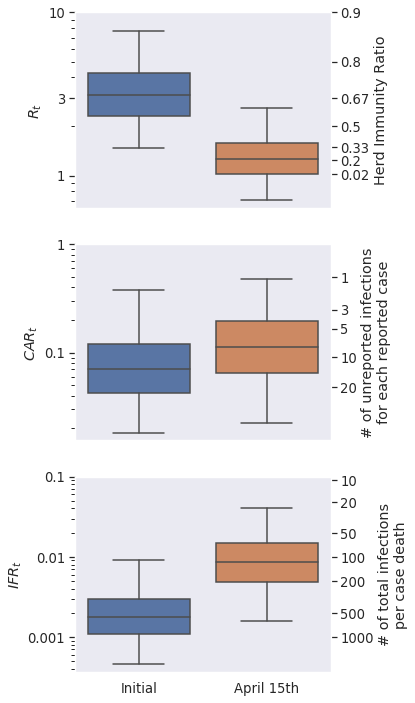

In [144]:
sns.set(style='dark', font_scale=1.2, rc={'ytick.left': True, 'ytick.right': False})
import matplotlib.ticker as mticker
gl = df.loc['AA Global']
quantiles = ['0.025', '0.25', '0.5', '0.75', '0.975']
fig, axes = plt.subplots(3, 1, figsize=(6, 10), sharex=True)
for i, pair in enumerate([('R0', 'Rt (April 15th)'), ('car (week 0)', 'car (April 15th)'), ('ifr (week 0)', 'ifr (April 15th)')]):
    ax = axes.flat[i]
    sns.boxplot(data=gl.loc[quantiles, pair], whis=99, ax=ax)
    ax.set_xlabel('');
    ax.set_yscale('log')
#axes.flat[0].set_yticks(range(9))
axes.flat[0].set_xticklabels(['Initial', 'April 15th'])
axes.flat[0].set_ylabel('$R_t$')
axes.flat[1].set_ylabel('$CAR_t$')
axes.flat[2].set_ylabel('$IFR_t$')

xticks = [1, 3, 10]
ax = axes.flat[0]
ax.set_yticks(xticks)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
axt = ax.twinx()
axt.set_yscale('log')
axt.set_ylim(*ax.get_ylim())
axt.minorticks_off()
axt.set_yticks([1.02, 1.25, 1.5, 2, 3, 5, 10])
axt.set_yticklabels(['%.2g' % (1 - 1/x) for x in axt.get_yticks()])
axt.set_ylabel('Herd Immunity Ratio')

xticks = [0.1, 1]
ax = axes.flat[1]
ax.set_yticks(xticks)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
axt = ax.twinx()
axt.set_yscale('log')
axt.set_ylim(*ax.get_ylim())
axt.minorticks_off()
axt.set_yticks([1/21, 1/11, 1/6, 1/4, 1/2])
axt.set_yticklabels(['%d' % (1/x - 1) for x in axt.get_yticks()])
axt.set_ylabel('# of unreported infections\nfor each reported case')


xticks = [0.001, 0.01, 0.1]
ax = axes.flat[2]
ax.set_yticks(xticks)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
axt = ax.twinx()
axt.set_yscale('log')
axt.set_ylim(*ax.get_ylim())
axt.minorticks_off()
axt.set_yticks([1/1001, 1/501, 1/201, 1/101, 1/51, 1/21, 1/11])
axt.set_yticklabels(['%d' % (1/x - 1) for x in axt.get_yticks()])
axt.set_ylabel('# of total infections\nper case death')

plt.tight_layout()

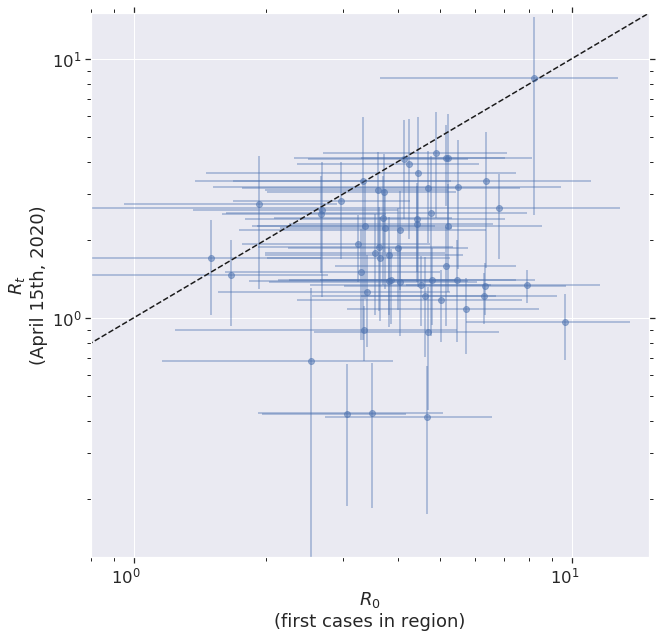

In [8]:
def stat_vs_stat(df, stat1, stat2):
    sns.set(font_scale=1.5, rc={'xtick.bottom': True, 'ytick.left': True, 'xtick.top': True, 'ytick.right': True})
    fig = plt.figure(figsize=(10, 10))
    clean1 = clean_df(df, stat1)
    clean2 = clean_df(df, stat2)
    plt.errorbar(clean1['0.5'], clean2['0.5'],
                 xerr=clean1['std'], yerr=clean2['std'],
                 color='b', marker='o', ls='none', alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    import matplotlib.transforms
    dx = 7/72.; dy = 0/72. 
    #ax.margins(x=0.01, y=0.01)
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in plt.gca().get_xticklabels():
        label.set_horizontalalignment('right')
        label.set_transform(label.get_transform() + offset)
    low = 0.08
    high = 15
    plt.plot([low, high], [low, high], 'k--')
    plt.xlim(0.8, 15)
    plt.ylim(0.12, 15)
    plt.xlabel('$R_0$\n(first cases in region)');
    plt.ylabel('$R_t$\n(April 15th, 2020)');
    
stat_vs_stat(df, 'R0', 'Rt (April 15th)');

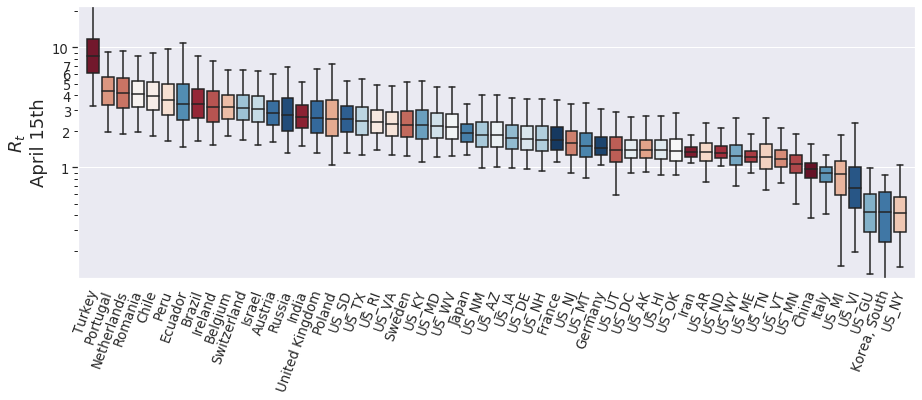